based on https://www.kaggle.com/code/dota2player/next-word-prediction-with-lstm-pytorch/notebook

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import demoji
import random
import matplotlib.pyplot as plt

import torchtext
import torchtext.vocab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

df = pd.read_csv(str(Path.cwd().parent / 'data' / 'medium_data.csv'))
df.head()


,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [3]:
def preprocessing_title(title):
    def remove_html_tags(title):
        soup = BeautifulSoup(title, 'html.parser')
        return soup.get_text()
    def remove_non_alphabetic(title):
        return re.sub('[^a-zA-Z]', ' ', title)
    def remove_imojis(title):
        return demoji.replace(title, '')

    title = remove_html_tags(title)
    title = remove_imojis(title)
    title = remove_non_alphabetic(title)
    title.replace(u'\xa0', u' ')
    title.replace('\x200a', ' ')
    return title

df_titles = df['title']
df_titles = df_titles.apply(preprocessing_title)

tokenizer = get_tokenizer('basic_english')
tokenized_titles = [tokenizer(title) for title in df_titles]
len(tokenized_titles)

6508

In [4]:
# feature vs. target vocab
# oov = out of vocabulary
# pad = padding

features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_titles,
    min_freq=2,
    specials=['<pad>', '<oov>'],
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_titles,
    min_freq=2
)

features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

print(f'Total number of words in features vocabulary: {features_vocab_total_words}')
print(f'Total number of words in target vocabulary: {target_vocab_total_words}')
print('-'*30)
print('Word -> ID')
print('<pad> -> '+ str(features_vocab['<pad>']))
print('<oov> -> '+ str(features_vocab['<oov>']))
print('embedding in feature vocab-> '+ str(features_vocab['embedding']))
print('embedding in target vocab-> '+ str(target_vocab['embedding']))

Total number of words in features vocabulary: 3571
Total number of words in target vocabulary: 3569
------------------------------
Word -> ID
<pad> -> 0
<oov> -> 1
embedding in feature vocab-> 1591
embedding in target vocab-> 1589


In [5]:
def text_to_numerical_sequence(tokenized_text):
    tokens_list = []
    if tokenized_text[-1] in target_vocab.get_itos():
        for token in tokenized_text[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_text[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

def add_random_oov_tokens(ngram):
    for idx, word in enumerate(ngram[:-1]):
        if random.uniform(0, 1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

def make_ngrams(tokenized_title):
    list_ngrams = []
    for i in range(1, len(tokenized_title)):
        ngram_sequence = tokenized_title[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

ngrams_list = []
for tokenized_title in tokenized_titles:
    ngrams_list.extend(make_ngrams(tokenized_title))
print(len(ngrams_list))

ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_tokens(ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))

input_sequences = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]
print(f'Total input sequences: {len(input_sequences)}')
print(input_sequences[7:9])

44910
True
Total input sequences: 41297
[[4, 511, 14, 63, 3, 446, 1591, 12, 2841], [4, 511, 1, 63, 3, 446, 1591, 12, 2843, 444]]


In [6]:
X = [sequence[:-1] for sequence in input_sequences] # type: ignore
y = [sequence[-1] for sequence in input_sequences] # type: ignore
len(X[0]), y[0]

(1, 509)

In [7]:
longest_sequence_feature = max(len(sequence) for sequence in X)
longest_sequence_feature

23

In [8]:
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence),
                                           0), value=0) for sequence in X]
padded_X[0], X[0], len(padded_X[0])


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4]),
 [4],
 23)

In [9]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)
type(y), type(padded_X)


(torch.Tensor, torch.Tensor)

In [10]:
y_one_hot = one_hot(y, num_classes=target_vocab_total_words)

data = TensorDataset(padded_X, y_one_hot)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32
train_data, test_data = random_split(data, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [11]:
class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) 
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output

embedding_dim = longest_sequence_feature
hidden_dim = 200
epochs = 50
model = My_LSTM(features_vocab_total_words, target_vocab_total_words, embedding_dim=embedding_dim, hidden_dim=hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

In [12]:
def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

model.to(device)

My_LSTM(
  (embedding): Embedding(3571, 23)
  (lstm): LSTM(23, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=3569, bias=True)
)

In [13]:
all_accuracies = []
all_losses = []
for epoch in range(epochs):   
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
            
    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())


Epoch 0/50, Loss: 7.3017, Train K-Accuracy: 12.51%
Epoch 5/50, Loss: 4.4730, Train K-Accuracy: 24.94%
Epoch 10/50, Loss: 4.3422, Train K-Accuracy: 39.64%
Epoch 15/50, Loss: 4.3048, Train K-Accuracy: 56.72%
Epoch 20/50, Loss: 3.4692, Train K-Accuracy: 68.70%
Epoch 25/50, Loss: 2.7993, Train K-Accuracy: 74.95%
Epoch 30/50, Loss: 3.0492, Train K-Accuracy: 78.87%
Epoch 35/50, Loss: 3.4385, Train K-Accuracy: 81.74%
Epoch 40/50, Loss: 1.4259, Train K-Accuracy: 83.56%
Epoch 45/50, Loss: 1.3268, Train K-Accuracy: 84.80%


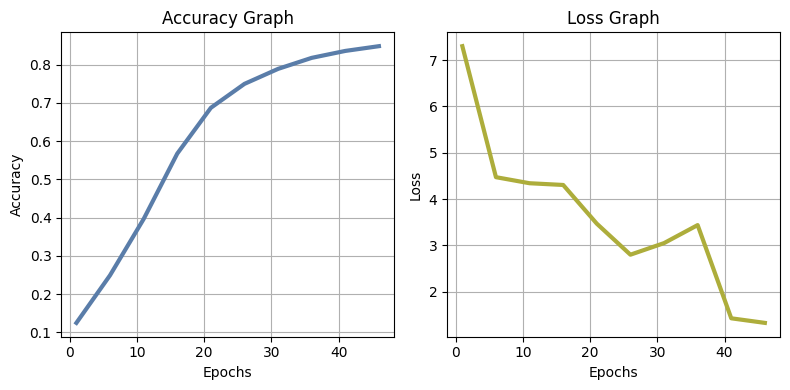

In [14]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [15]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')


Test K-Accuracy: 20.52%


In [16]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

def use_model(input_list):
    model.eval()
    output_list = []
    for data in input_test:
        sentence = data[0]
        num_words = data[1]
        for i in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test),
                                                         (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0),
                                                         value=0)
            output_test_walking = torch.argmax(model(padded_tokenized_sequence_input_test.unsqueeze(0)))
            sentence = sentence + ' ' + target_vocab.lookup_token(output_test_walking.item()) # type: ignore
        output_list.append(sentence)
    return output_list

input_test = [['stand', 5], ['deep learning is', 5], ['data cleaning', 4], ['6 ways', 4], ['you did a', 2]]
outputs_model = use_model(input_test)
outputs_model


['stand up your own javascript growth',
 'deep learning is the of the future of',
 'data cleaning investor data science and',
 '6 ways to improve your writing',
 'you did a writer s']